In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import preprocessing
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from keras.optimizers import Adam, SGD


from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from keras.optimizers import RMSprop
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler

import random
import time
import cv2
from tqdm import tqdm

Num GPUs Available:  0


## Data expoloration

In [2]:
image_folder = "./Flipkart/Images/"
# Load CSV into Pandas DataFrame
text_data_path = r'./Flipkart/flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(text_data_path)
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
386,59d964c38c787f829c6cfa5629e4df90,2015-12-01 06:13:00 +0000,http://www.flipkart.com/french-factor-man-year...,French Factor Man of the Year Deodorant Gift S...,"[""Beauty and Personal Care >> Fragrances >> De...",CAGE4GF7UWGZHN7J,360.0,340.0,59d964c38c787f829c6cfa5629e4df90.jpg,False,Flipkart.com: Buy French Factor Man of the Yea...,4.5,4.5,NaN,"{""product_specification""=>[{""key""=>""Gift Set C..."
841,01089dc3618a0ab7304d784ef400b83d,2015-12-29 05:07:38 +0000,http://www.flipkart.com/kliqvik-six-port-usb-h...,KLIQVIK SIX PORT USB HUB FOR I PHONE 4 MOBILES...,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEDZF2Y87ECZHK,1499.0,1099.0,01089dc3618a0ab7304d784ef400b83d.jpg,False,Buy KLIQVIK SIX PORT USB HUB FOR I PHONE 4 MOB...,No rating available,No rating available,KLIQVIK,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
722,7091af252a785131c5a124fb90705fda,2016-01-01 19:37:22 +0000,http://www.flipkart.com/sapatos-plain-single-d...,Sapatos Plain Single Duvet Red,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAEEJGJHFZPF2Y2,2999.0,1499.0,7091af252a785131c5a124fb90705fda.jpg,False,Sapatos Plain Single Duvet Red (Single duvet)\...,No rating available,No rating available,Sapatos,"{""product_specification""=>[{""key""=>""Machine Wa..."
586,87e0ba259a84a10580bd659466e73e23,2016-01-07 05:50:25 +0000,http://www.flipkart.com/sf-sonata-7963pp02-dea...,SF by Sonata 7963PP02 Dean Analog Watch - For...,"[""Watches >> Wrist Watches >> SF by Sonata Wri...",WATDA5ZA3Z3UJJJQ,749.0,749.0,87e0ba259a84a10580bd659466e73e23.jpg,True,SF by Sonata 7963PP02 Dean Analog Watch - For...,4.7,4.7,NaN,"{""product_specification""=>[{""key""=>""Mechanism""..."
582,a7bd63ef1d3b345d7f9a162865bb7c0d,2016-01-07 05:50:25 +0000,http://www.flipkart.com/flippd-fd040149-casual...,Flippd FD040149 Casual Analog Watch - For Wom...,"[""Watches >> Wrist Watches >> Flippd Wrist Wat...",WATE8E8PGC6SARZG,999.0,999.0,a7bd63ef1d3b345d7f9a162865bb7c0d.jpg,True,Flippd FD040149 Casual Analog Watch - For Wom...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."


In [3]:
# Check if each product has only one corresponding image
image_counts = df['image'].value_counts()
duplicates = image_counts[image_counts > 1].index.tolist()

if not duplicates:
    print("Each product has only one corresponding image.")
else:
    print("Some products have more than one corresponding image. Duplicates:")
    print(duplicates)

# Use listdir to get the list of image files in the folder
folder_images = set(os.listdir(image_folder))

# Check if each image in the dataset has a corresponding file in the specified folder
missing_images = [image for image in df['image'] if image not in folder_images]

if not missing_images:
    print("All images in the dataset have corresponding files in the folder.")
else:
    print("Some images in the dataset do not have corresponding files in the folder. Missing images:")
    print(missing_images)

Each product has only one corresponding image.
All images in the dataset have corresponding files in the folder.


In [4]:
# Split the product_category_tree column into subcategory columns and keep only the 2 first catagory levels
category_lables = df['product_category_tree'].str.split(' >> ', expand=True).iloc[:, :2][0]

# Remove square brackets and double quotes from all strings in the DataFrame
df['category'] = category_lables.apply(lambda x: str(x).replace('[', '').replace('"', '').replace(']', ''))
list_categories = df['category'].unique().tolist()
df['category']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category, Length: 1050, dtype: object

In [5]:
le = preprocessing.LabelEncoder()
le.fit(df["category"])
df['category_encoded'] = le.transform(df["category"])
category_dict = dict(zip(df['category'], df['category_encoded']))
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

In [6]:
df.groupby("category_encoded").count()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
category_encoded,,,,,,,,,,,,,,,,
0,150,150,150,150,150,150,149,149,150,150,150,150,150,134,150,150
1,150,150,150,150,150,150,150,150,150,150,150,150,150,41,150,150
2,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
3,150,150,150,150,150,150,150,150,150,150,150,150,150,148,149,150
4,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
5,150,150,150,150,150,150,150,150,150,150,150,150,150,79,150,150
6,150,150,150,150,150,150,150,150,150,150,150,150,150,10,150,150


Home Furnishing


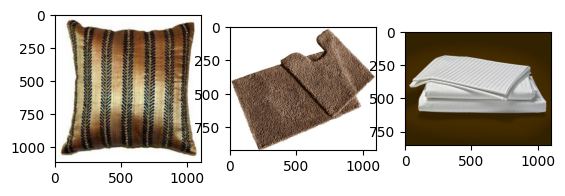

Baby Care


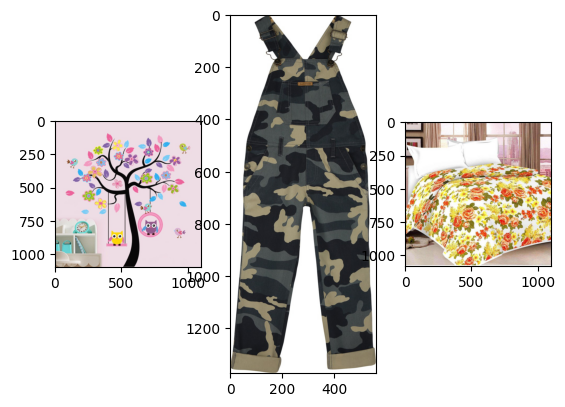

Watches


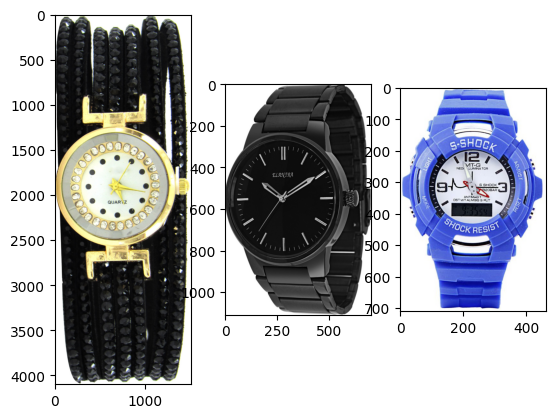

Home Decor & Festive Needs


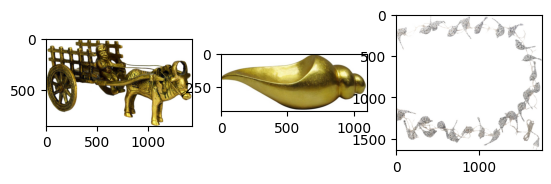

Kitchen & Dining


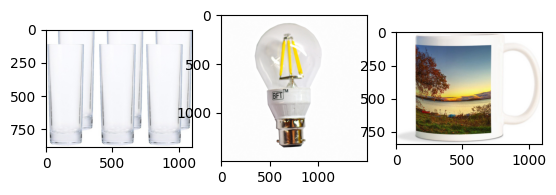

Beauty and Personal Care


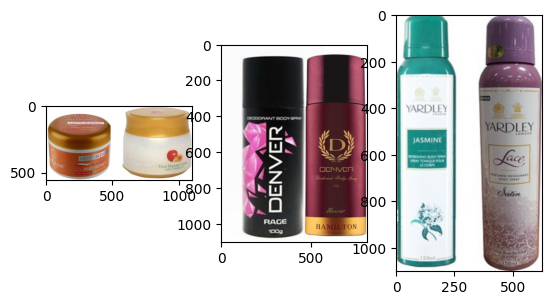

Computers


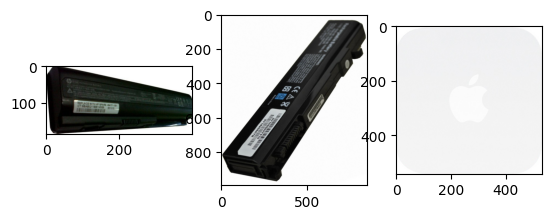

In [7]:
def list_fct(category) :
    list_image_name = [df["image"][i] for i in range(len(df)) if df["category"][i]==category]
    return list_image_name

for category in list_categories :
    print(category)

    # Get 3 random ids from the list
    random_values = random.sample(list_fct(category), 3)
    #print(random_values)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = random_values[i]
        image = imread(glob(os.path.join(image_folder, filename))[0])
        plt.imshow(image)
    plt.show()

# Step 1 : feasability study

#### 0 - Utility functions

* Metrics

In [8]:
def calculate_ari(labels_true, labels_pred):
    ari = np.round(adjusted_rand_score(labels_true, labels_pred), 2)
    return ari

def calculate_silhouette_score(data, labels):
    silhouette = np.round(silhouette_score(data, labels), 2)
    return silhouette

* Kmeans

In [9]:
def Kmeans_Metrics(X_tsne, df_tsne, num_clusters):
    # Determine clusters from the data after dimensiality reduction (SVD)
    kmeans = KMeans(n_clusters=num_clusters, n_init=100)
    kmeans.fit(X_tsne)

    # Metrics
    ARI = calculate_ari(df_tsne.category_encoded, kmeans.labels_)
    SILOUHETTE = calculate_silhouette_score(X_tsne, kmeans.labels_)

    return ARI, SILOUHETTE, kmeans.labels_

* PCA Function

In [10]:
def apply_pca(data, variance_threshold=0.99):
    # Print dimensions before PCA reduction
    print("Dimensions before PCA reduction:", data.shape)

    # Create a PCA object with n_components set to preserve specified variance
    pca = PCA(n_components=variance_threshold)

    # Fit and transform the original features using PCA
    transformed_data = pca.fit_transform(data)

    # Print dimensions after PCA reduction
    print("Dimensions after PCA reduction:", transformed_data.shape)

    return transformed_data

* TSNE Function

In [11]:
def apply_tsne_kmeans(pca_features, num_clusters, tsne_params=None):
    # Create a t-SNE object with specified parameters
    tsne = manifold.TSNE(**(tsne_params or {}))

    # Fit and transform the data using t-SNE on the PCA-reduced features
    X_tsne = tsne.fit_transform(pca_features)
    # Create a DataFrame to store the t-SNE results
    df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
    df_tsne["category"] = df["category"]
    df_tsne["category_encoded"] = df["category_encoded"]

    # X_tsne to Kmeans clusters
    ARI, SILOUHETTE, kmeansLabels = Kmeans_Metrics(X_tsne, df_tsne, num_clusters)

    df_tsne["Kmeans_cluster"] = kmeansLabels


    # Print the shape of the t-SNE DataFrame
    print("X_tsne shape:", X_tsne.shape)

    return X_tsne, df_tsne, ARI, SILOUHETTE

* Confusion Matrix

In [164]:
def remove_duplicate(arr):
    count_dict = {}
    
    for num in arr:
        count_dict[num] = count_dict.get(num, 0) + 1
    missing_numbers = []

    for mn in range(arr.shape[0]):
        if len(missing_numbers) != len(arr) - len(set(arr)):
            missing_number = next(x for x in range(len(arr)) if x not in count_dict and x not in missing_numbers)
            missing_numbers.append(missing_number)

    replaced_second_occurrence = {}
    result_array = []

    for num in np.unique(np.flip(arr)):
        replaced_second_occurrence[num] = False

    for num in np.flip(arr):
        count = count_dict[num]
        if count > 1 and not replaced_second_occurrence.get(num, False):
            result_array.append(missing_numbers.pop(0))
            replaced_second_occurrence[num] = True
        else:
            result_array.append(num)

    return np.flip(result_array)


def conf_mat_transform(dftsne):
    y_true = dftsne.category_encoded
    y_pred = dftsne.Kmeans_cluster

    # Step 1: Compute the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    print(conf_mat)
    
    # Step 2: Find the correspondence between clusters
    corresp = np.argmax(conf_mat, axis=0)
    print('corresp: ' + str(corresp))

    # If corresp has repeating numbers, use remove_duplicate
    if len(np.unique(corresp)) != len(corresp):
        corresp = remove_duplicate(corresp)
        print('corresp2: ' + str(corresp))
    
    # Step 3: Transform predicted labels based on correspondence
    y_pred_transform = y_pred.apply(lambda x : corresp[x]) 

    # Add the 'Transformed_Cluster' column to dftsne
    dftsne['Transformed_Cluster'] = y_pred_transform

    # Rearrange the confusion matrix to have maximum values on the diagonal
    conf_mat_transf = confusion_matrix(y_true, y_pred_transform)
    
    unique_values, unique_indices = np.unique(y_pred_transform, return_index=True)
    # Sort by the order of appearance
    sorted_indices = np.argsort(unique_indices)

    # Convert sorted_indices to a list
    #sorted_indices_list = list(sorted_indices)
    sorted_indices_list = [0, 1, 2, 3, 4, 5, 6]

    # Use sorted with a custom key function
    category_name = [key for key, value in sorted(category_dict.items(), key=lambda x: sorted_indices_list.index(x[1]))]

    df_cm_transf = pd.DataFrame(conf_mat_transf, index=category_name, columns=sorted_indices_list)
    print(df_cm_transf)
    print(sorted_indices_list)
    print(category_name)


    fig = plt.figure(figsize=(25, 11))
    ax = fig.add_subplot(121)
    cm1 = sns.heatmap(df_cm_transf, annot=True, fmt="d", cmap="Reds")
    plt.title('Transformed confusion matrix')

    ax = fig.add_subplot(122)
    cm2 = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds")
    plt.title('Confusion matrix after Kmeans')

    plt.show()

    # Classification report:
    print(classification_report(dftsne.category_encoded, dftsne.Transformed_Cluster))

    return df_cm_transf, dftsne, category_name, sorted_indices


* TSNE VISUALIZATION

In [151]:
# Visualize TSNE visualization based on true categories and cluster numbers
def TSNE_visualization(X_tsne, category_reindexed, df_tsne, ARI, SILOUHETTE):
    fig = plt.figure(figsize=(25, 11))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tsne.category_encoded, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=category_reindexed, loc="best", title="Category")
    plt.title('Representation of products by categories')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tsne['Transformed_Cluster'], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=category_reindexed, loc="best", title="Clusters")
    #ax.legend(handles=scatter.legend_elements()[0], labels=list(df_tsne.Transformed_Cluster.unique()), loc="best", title="Clusters")
    plt.title('Representation of products by Kmeans clusters')

    plt.show()
    print("ARI: ", ARI, " / ", "SILOUHETTE: ", SILOUHETTE)
    print(list(df_tsne.category_encoded.unique()))
    print(list(df_tsne.Transformed_Cluster.unique()))

#category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]

# Now, use the modified df_tsne for the t-SNE visualization
#TSNE_visualization(X_tsne, category_reindexed, df_tsne, ARI, SILOUHETTE, columns_to_process[0])


#### 1 - Bag of Visual Words: SIFT / CLAHE / KMEANS / TSNE

* CLAHE + SIFT FEATURES

In [14]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
sift = cv2.SIFT_create()

# Function to apply Gray + CLAHE for image enhancement
def apply_gray_clahe(image_path):
    # Read and preprocess the test image
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    return clahe.apply(image_gray)

# Function to extract SIFT features from an image
def extract_sift_features(image):
    # Create SIFT detector
    keypoints, descriptors = sift.detectAndCompute(image, None)
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    # Detect and compute SIFT features
    return image_with_keypoints, descriptors

Descriptors shape: (2123, 128)

 [[16.  2.  0. ...  0.  0.  2.]
 [34. 90.  0. ...  0.  0.  0.]
 [12.  1.  0. ...  0.  0.  0.]
 ...
 [64. 79. 12. ...  0.  0.  1.]
 [10. 18. 13. ...  0.  0.  0.]
 [41. 29.  0. ...  2.  7. 11.]]


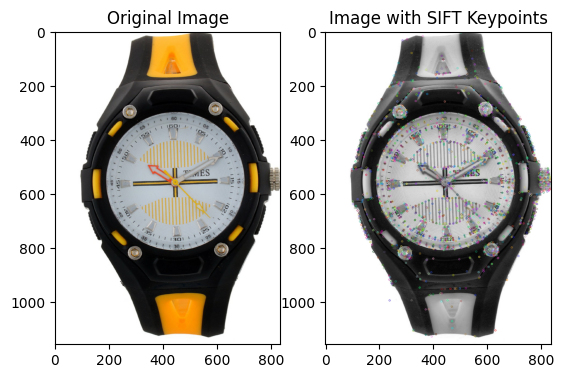

In [15]:
# Choose a test image (e.g., the 100th image in the folder)
example_image_path = glob(os.path.join(image_folder, os.listdir(image_folder)[100]))[0]
image = imread(example_image_path)

# Read and preprocess the test image
image_clahe = apply_gray_clahe(example_image_path)

# Detect and compute SIFT features
image_with_keypoints, descriptors = extract_sift_features(image_clahe)

# Display descriptors
print("Descriptors shape:", descriptors.shape)
print("\n", descriptors)

# Display original and processed images
plt.subplot(121)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(122)
plt.imshow(image_with_keypoints)
plt.title("Image with SIFT Keypoints")

plt.show()


In [16]:
# List to store SIFT descriptors
sift_descriptors = []
start_time = time.time()

# Assuming df is your DataFrame
for filename in tqdm(df.image.tolist(), desc="Processing Images"):
    img_path = glob(os.path.join(image_folder, filename))[0]

    # Read and preprocess the test image
    image_clahe = apply_gray_clahe(img_path)    
    # Detect and compute SIFT features
    image_with_keypoints, descriptors = extract_sift_features(image_clahe)  
    sift_descriptors.append(descriptors)    
# Convert to NumPy arrays
sift_descriptors_by_img = np.asarray(sift_descriptors)
sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)

# Display results
print("Descriptors numbers: {}".format(sift_descriptors_all.shape[0]))
print("Processing time for SIFT descriptors: {:.2f} secondes".format(time.time() - start_time))


Processing Images:   0%|          | 0/1050 [00:00<?, ?it/s]

Processing Images: 100%|██████████| 1050/1050 [26:42<00:00,  1.53s/it] 
C:\Users\Imtech\AppData\Local\Temp\ipykernel_16760\1123594845.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_descriptors_by_img = np.asarray(sift_descriptors)


Descriptors numbers: 9049503
Processing time for SIFT descriptors: 1614.19 secondes


In [17]:
# Determining the number of clusters
start_time = time.time()

estimated_clusters = int(round(np.sqrt(len(sift_descriptors_all)), 0))
# Alternatively, you can set a fixed number of clusters (e.g., k = 70)
# estimated_clusters = 70

print("Estimated number of clusters:", estimated_clusters)
print(f"Creating {estimated_clusters} clusters of descriptors...")

# Clustering using MiniBatchKMeans
MBkmeans = MiniBatchKMeans(n_clusters=estimated_clusters, init_size=3 * estimated_clusters)
MBkmeans.fit(sift_descriptors_all)

duration_kmeans = time.time() - start_time
print("Processing time for MBkmeans:", "{:.2f} seconds".format(duration_kmeans))


Estimated number of clusters: 3008
Creating 3008 clusters of descriptors...


c:\Users\Imtech\anaconda3\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Imtech\anaconda3\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Processing time for MBkmeans: 4111.05 seconds


In [18]:
# Function to build histogram for an image's descriptors
def build_histogram(kmeans, descriptors, image_num):
    # Predict cluster labels for each descriptor
    cluster_labels = kmeans.predict(descriptors)
    
    # Initialize histogram
    histogram = np.zeros(len(kmeans.cluster_centers_))
    
    # Number of descriptors in the image
    n_descriptors = len(descriptors)
    
    # Check if there are descriptors in the image
    if n_descriptors == 0:
        print("Issue with histogram for image:", image_num)
    
    # Build histogram
    for label in cluster_labels:
        histogram[label] += 1.0 / n_descriptors
    
    return histogram

# Creation of a matrix of histograms
start_time = time.time()

hist_vectors = []
for i, image_descriptors in tqdm(enumerate(sift_descriptors_by_img)):    
    # Build histogram for the image's descriptors
    hist = build_histogram(MBkmeans, image_descriptors, i)
    
    # Append histogram to the list (feature vectors)
    hist_vectors.append(hist)

# Convert the list of histograms to a NumPy array
im_features = np.asarray(hist_vectors)

duration_histograms = time.time() - start_time
print("Processing time for creating histograms:", "{:.2f} seconds".format(duration_histograms))

1050it [07:12,  2.43it/s]

Processing time for creating histograms: 432.54 seconds


In [19]:
im_features.shape

(1050, 3008)

##### Dimensionality Reduction using PCA

In [20]:
feat_pca = apply_pca(im_features)

Dimensions before PCA reduction: (1050, 3008)
Dimensions after PCA reduction: (1050, 651)


##### T-SNE Dimensionality Reduction and Display of Images According to True Classes

In [21]:
X_tsne, df_tsne, ARI, SILOUHETTE = apply_tsne_kmeans(feat_pca, num_clusters=7, tsne_params=None)

# Print the shape of the t-SNE DataFrame
print("Dimensions of the X_tsne:", X_tsne.shape)

c:\Users\Imtech\anaconda3\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


X_tsne shape: (1050, 2)
Dimensions of the X_tsne: (1050, 2)


In [22]:
df_tsne

,tsne1,tsne2,category,category_encoded,Kmeans_cluster
0,20.364037,-14.562558,Home Furnishing,4,2
1,12.055237,-1.698649,Baby Care,0,2
2,17.292635,-8.039358,Baby Care,0,2
3,20.410183,0.875734,Home Furnishing,4,2
4,12.078783,-3.107746,Home Furnishing,4,2
...,...,...,...,...,...
1045,-0.728299,15.152951,Baby Care,0,3
1046,-26.357637,4.612658,Baby Care,0,1
1047,2.890701,11.044218,Baby Care,0,3
1048,-27.776524,4.979708,Baby Care,0,1


* Then we need to match the initial truth labels (Encoded categories) with K-means cluster labels to maximize correct predictions. This is a quick and basic approach. If predictions are accurate and each group has similar sample sizes, it works well. Otherwise, it may lead to mismatches and overestimate clustering quality

In [23]:
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

* Confusion Matrix

[[28 14 37 24 16 11 20]
 [21  6 14 38 14 24 33]
 [18 37  8 18 43 18  8]
 [60 12 15  6  9 11 37]
 [31  5 52 11 17  6 28]
 [23 24 16 28 33 16 10]
 [27 58  4  6 30 17  8]]
corresp: [3 6 4 1 2 1 3]
corresp2: [3 6 4 1 2 5 0]
[4, 2, 6, 5, 1, 0, 3]


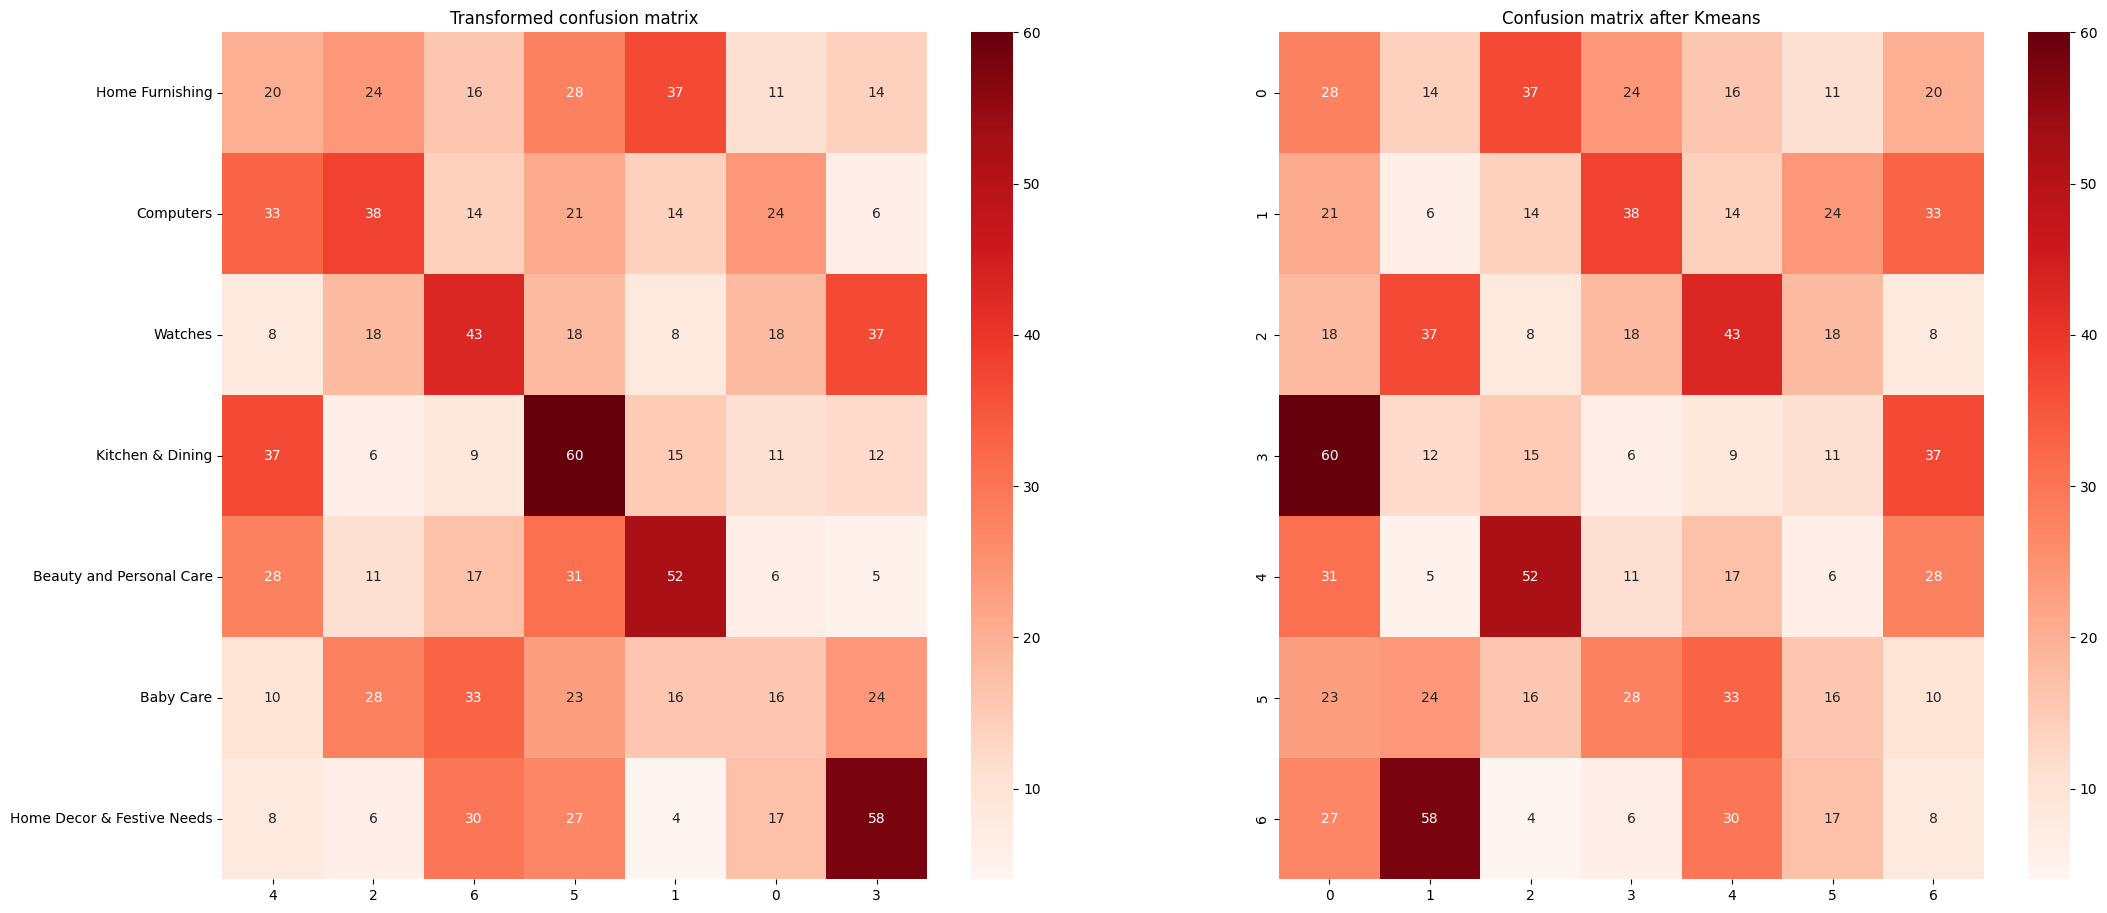

              precision    recall  f1-score   support

           0       0.14      0.13      0.14       150
           1       0.29      0.25      0.27       150
           2       0.27      0.29      0.28       150
           3       0.29      0.40      0.34       150
           4       0.36      0.35      0.35       150
           5       0.16      0.11      0.13       150
           6       0.37      0.39      0.38       150

    accuracy                           0.27      1050
   macro avg       0.27      0.27      0.27      1050
weighted avg       0.27      0.27      0.27      1050



In [24]:
df_cm_transf, df_tsne, category_name, sorted_indices = conf_mat_transform(df_tsne)

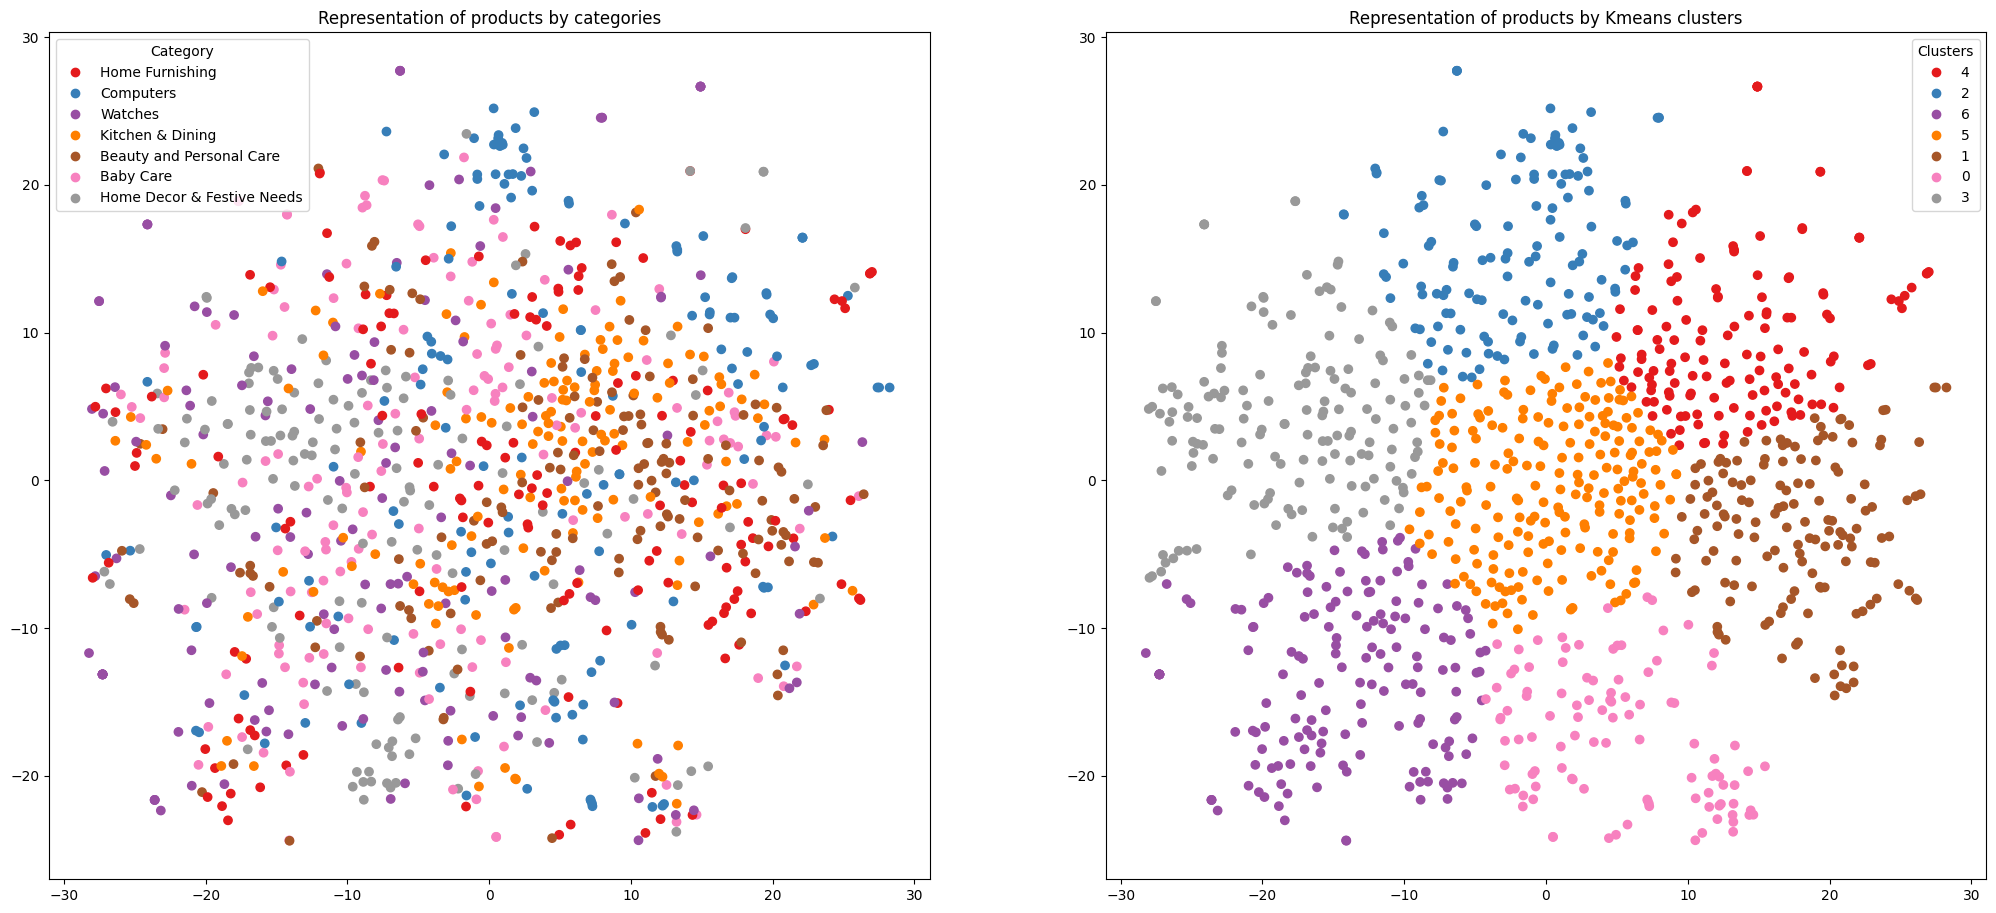

ARI:  0.05  /  SILOUHETTE:  0.35


In [25]:
category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]

# Now, use the modified df_tsne for the t-SNE visualization
TSNE_visualization(X_tsne, category_reindexed, df_tsne, ARI, SILOUHETTE)


SESSION1 faire sift + data augmentation

* The ARI score is too low: ARI = 0.05 / 0.06
* The confusion matrix needs to be rearranged so that the categories assumed in the columns follow the same order as those in the rows

In [26]:
df_tsne.groupby("Kmeans_cluster").count()['category']

Kmeans_cluster
0    208
1    156
2    146
3    131
4    162
5    103
6    144
Name: category, dtype: int64

In [27]:
import plotly.graph_objects as go

counts = np.bincount(df_tsne.Kmeans_cluster)
labels = np.unique(df_tsne.Kmeans_cluster)
#category_name = np.array([next((key for key, value in category_dict.items() if value == label), None) for label in labels])

# NUMBER OF CUSTOMERS BY CLUSTER
#fig = go.Figure(data=[go.Pie(labels=category_name,
fig = go.Figure(data=[go.Pie(labels=df_tsne.groupby('Kmeans_cluster').count()['category'].index,
                             title='NUMBER OF IMAGES BY CLUSTER\n\n',
                             title_font_size=25,
#                             values=counts)])
                             values=df_tsne.groupby('Kmeans_cluster').count()['category'])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  #marker=dict(colors=colors, line=dict(color='#000000', width=2))
                 )
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

#### 2 - CNN Transfer Learning Approach

* Creation of the CNN pre-trained models

In [28]:
model_vgg = VGG16()
model_resnet = ResNet50(weights='imagenet')

model_vgg = Model(inputs=model_vgg.inputs, outputs=model_vgg.layers[-2].output)
model_resnet = Model(inputs=model_resnet.inputs, outputs=model_resnet.layers[-2].output)

In [29]:
images_features_vgg = []
images_features_resnet = []

for filename in tqdm(df.image):
    image_path = glob(os.path.join(image_folder, filename))[0]
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features_vgg.append(model_vgg.predict(image, verbose=0)[0]) # predict from pretrained model
    images_features_resnet.append(model_resnet.predict(image, verbose=0)[0]) # predict from pretrained model

images_features_vgg = np.asarray(images_features_vgg)
images_features_resnet = np.asarray(images_features_resnet)

images_features_vgg.shape, images_features_vgg.shape

  0%|          | 0/1050 [00:00<?, ?it/s]

100%|██████████| 1050/1050 [20:02<00:00,  1.15s/it]


((1050, 4096), (1050, 4096))

(-0.5, 223.5, 223.5, -0.5)

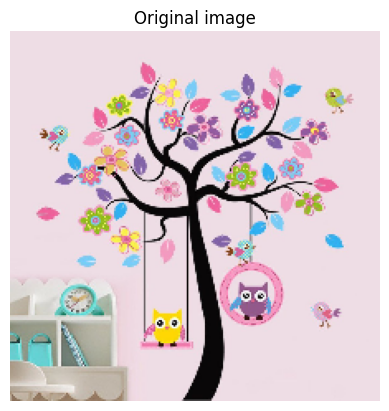

In [30]:
image_path = glob(os.path.join(image_folder, filename))[0]
image = load_img(image_path, target_size=(224, 224))

fig = plt.figure()
plt.title('Original image')
plt.imshow(image)
plt.axis("off")

##### 2 -1 - VGG16

In [31]:
#pip install opencv-python==3.4.18.65 opencv-contrib-python==3.4.18.65

* Pre-trained resnet16 model + removing the final classification layer.

In [32]:
print(model_vgg.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

 * Make image features

##### Dimensionality Reduction using PCA

In [33]:
feat_pca_vgg = apply_pca(images_features_vgg)

Dimensions before PCA reduction: (1050, 4096)
Dimensions after PCA reduction: (1050, 803)


##### T-SNE Dimensionality Reduction and Display of Images According to True Classes

In [34]:
X_tsne_vgg, df_tsne_vgg, ARI_vgg, SILOUHETTE_vgg = apply_tsne_kmeans(feat_pca_vgg, num_clusters=7, tsne_params=None)

# Print the shape of the t-SNE DataFrame
print("Dimensions of the X_tsne:", X_tsne_vgg.shape)

c:\Users\Imtech\anaconda3\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



X_tsne shape: (1050, 2)
Dimensions of the X_tsne: (1050, 2)


* Confusion Matrix

[[  1  28   1   1 108   3   8]
 [  1  13   1   8   4 117   6]
 [  1  34   0 113   1   1   0]
 [  8  77   0   5   2   1  57]
 [  0   6   0   0  76   0  68]
 [  0  30  79  32   0   9   0]
 [135   2   0  13   0   0   0]]
corresp: [6 3 5 2 0 1 4]
                              4    0    6   2   3   1    5
Home Furnishing             108    3    1  28   8   1    1
Baby Care                     4  117    8  13   6   1    1
Watches                       1    1  113  34   0   0    1
Computers                     2    1    5  77  57   0    8
Home Decor & Festive Needs   76    0    0   6  68   0    0
Beauty and Personal Care      0    9   32  30   0  79    0
Kitchen & Dining              0    0   13   2   0   0  135
[4, 0, 6, 2, 3, 1, 5]
['Home Furnishing', 'Baby Care', 'Watches', 'Computers', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Kitchen & Dining']


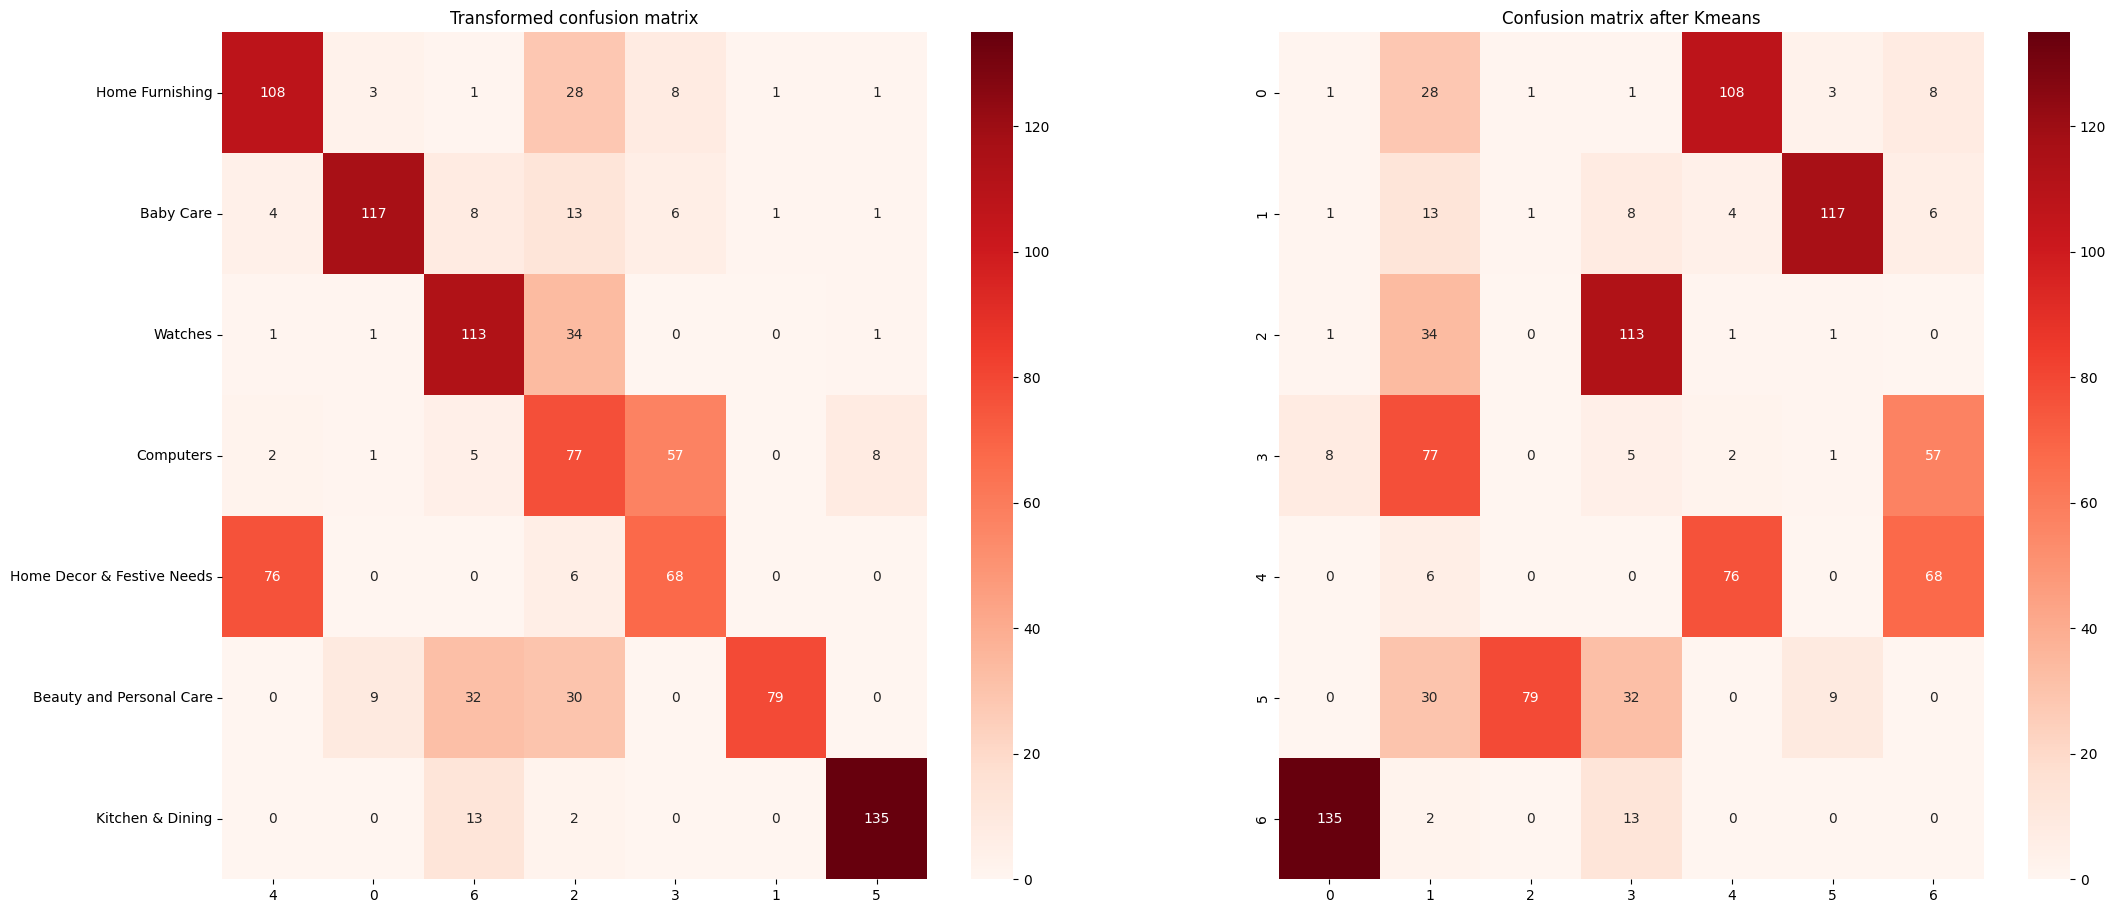

              precision    recall  f1-score   support

           0       0.57      0.72      0.63       150
           1       0.89      0.78      0.83       150
           2       0.66      0.75      0.70       150
           3       0.41      0.51      0.45       150
           4       0.49      0.45      0.47       150
           5       0.98      0.53      0.68       150
           6       0.92      0.90      0.91       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



In [133]:
df_cm_transf_vgg, df_tsne_vgg, category_name_vgg, sorted_indices_vgg = conf_mat_transform(df_tsne_vgg)

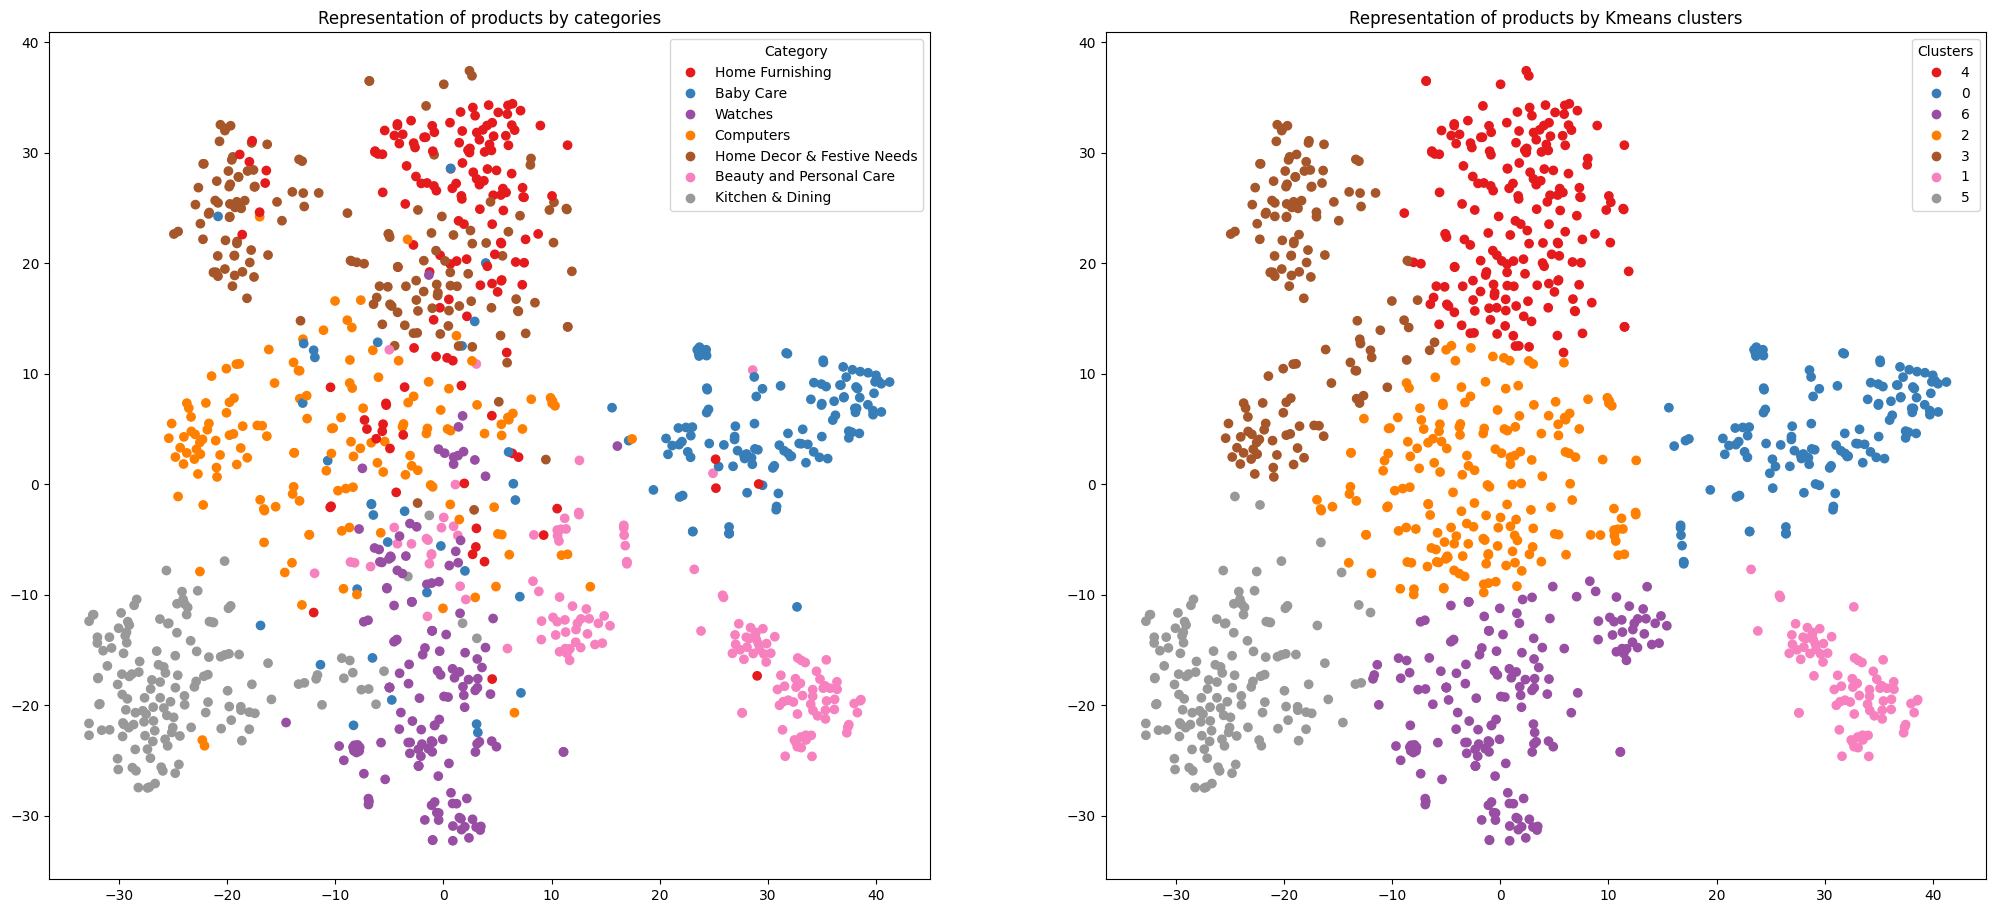

ARI:  0.45  /  SILOUHETTE:  0.49


In [134]:
TSNE_visualization(X_tsne_vgg, category_name_vgg, df_tsne_vgg, ARI_vgg, SILOUHETTE_vgg)

##### 2-2 - RESNET50

In [37]:
print(model_resnet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

 * Make image features

##### Dimensionality Reduction using PCA

In [38]:
feat_pca_resnet = apply_pca(images_features_resnet)

Dimensions before PCA reduction: (1050, 2048)


Dimensions after PCA reduction: (1050, 722)


##### T-SNE Dimensionality Reduction and Display of Images According to True Classes

In [135]:
X_tsne_resnet, df_tsne_resnet, ARI_resnet, SILOUHETTE_resnet = apply_tsne_kmeans(feat_pca_resnet, num_clusters=7, tsne_params=None)
print("Dimensions of the X_tsne:", X_tsne_resnet.shape)

c:\Users\Imtech\anaconda3\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



X_tsne shape: (1050, 2)
Dimensions of the X_tsne: (1050, 2)


In [157]:
category_reindexed_resnet

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Computers',
 'Beauty and Personal Care',
 'Kitchen & Dining',
 'Home Decor & Festive Needs']

* Confusion Matrix

[[  9   8  20   1 108   2   2]
 [ 16   7   2   1   5   2 117]
 [129   4   9   3   1   1   3]
 [  8  92  31   5   6   5   3]
 [  0   5  77   0  65   0   3]
 [ 27   5   0 114   0   0   4]
 [  1   3   0   0   0 146   0]]
corresp: [2 3 4 5 0 6 1]
                              0    1    2   3   4    5    6
Baby Care                   108    2    9   8  20    1    2
Beauty and Personal Care      5  117   16   7   2    1    2
Computers                     1    3  129   4   9    3    1
Home Decor & Festive Needs    6    3    8  92  31    5    5
Home Furnishing              65    3    0   5  77    0    0
Kitchen & Dining              0    4   27   5   0  114    0
Watches                       0    0    1   3   0    0  146
[0, 1, 2, 3, 4, 5, 6]
['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


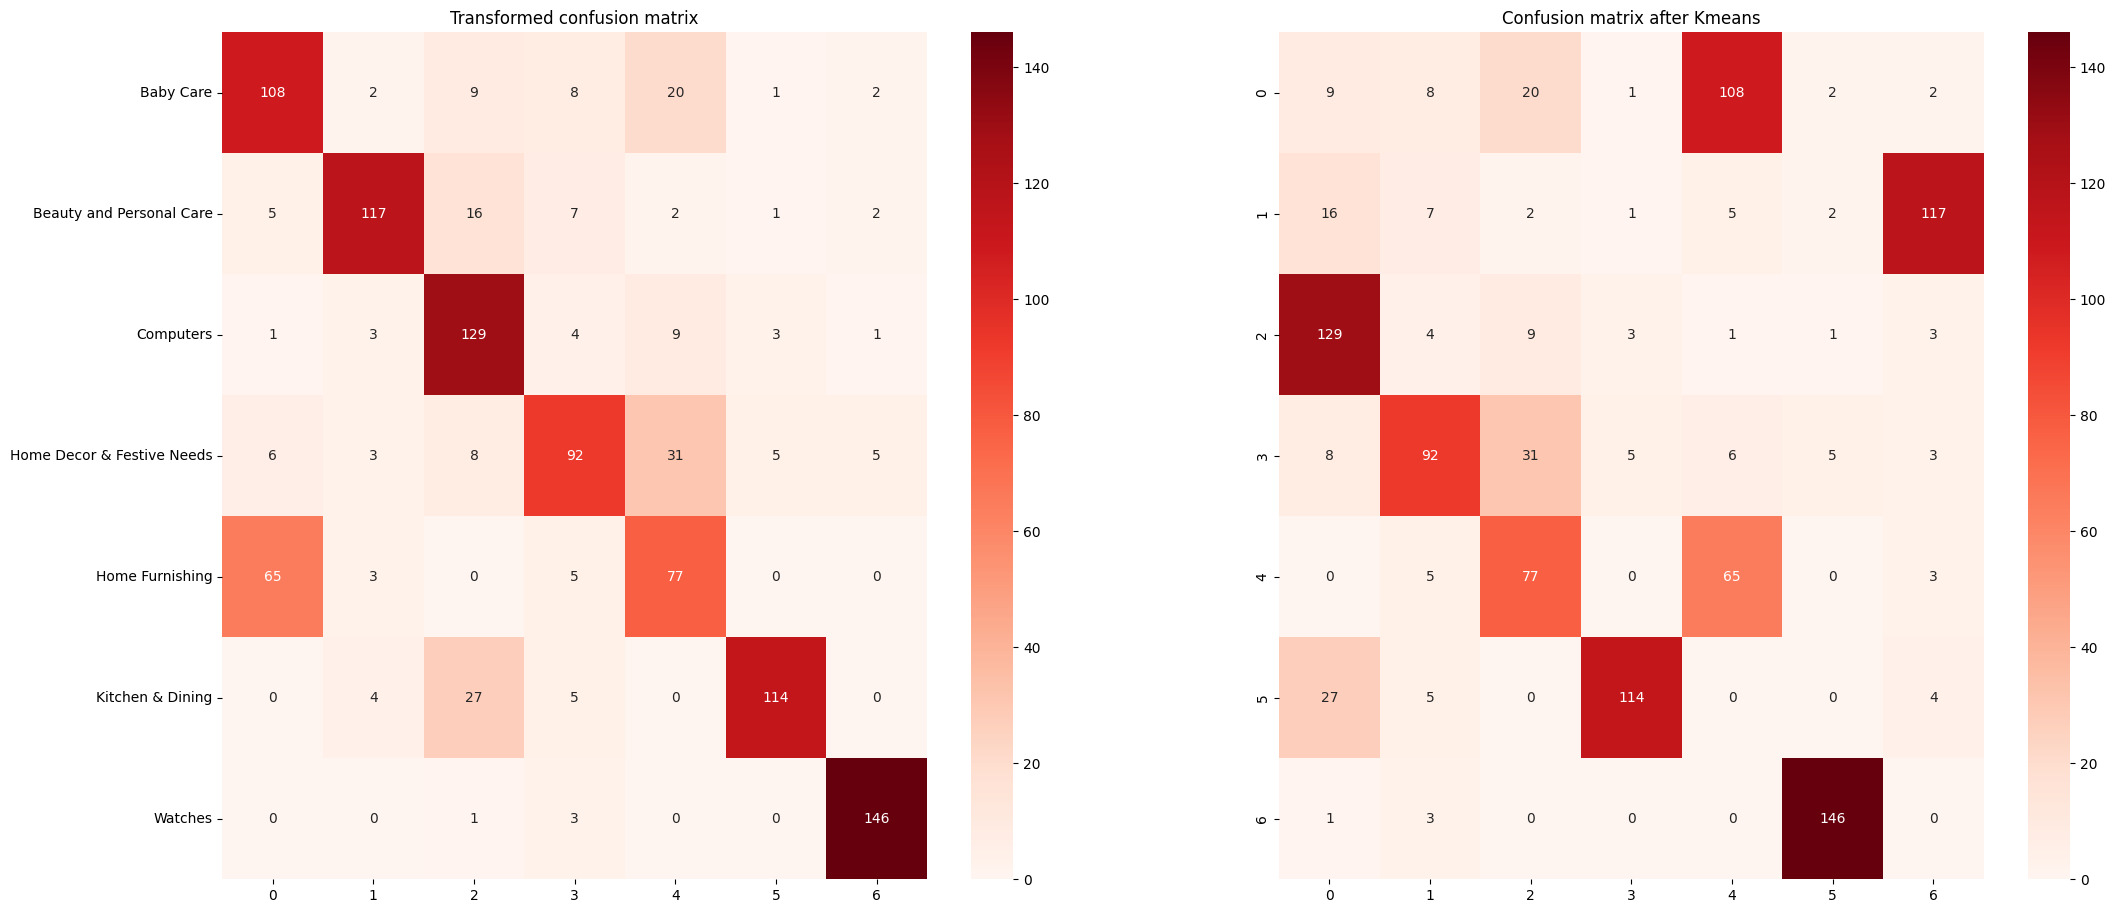

              precision    recall  f1-score   support

           0       0.58      0.72      0.64       150
           1       0.89      0.78      0.83       150
           2       0.68      0.86      0.76       150
           3       0.74      0.61      0.67       150
           4       0.55      0.51      0.53       150
           5       0.92      0.76      0.83       150
           6       0.94      0.97      0.95       150

    accuracy                           0.75      1050
   macro avg       0.76      0.75      0.75      1050
weighted avg       0.76      0.75      0.75      1050



In [165]:
df_cm_transf_resnet, df_tsne_resnet, category_name_resnet, sorted_indices_resnet = conf_mat_transform(df_tsne_resnet)

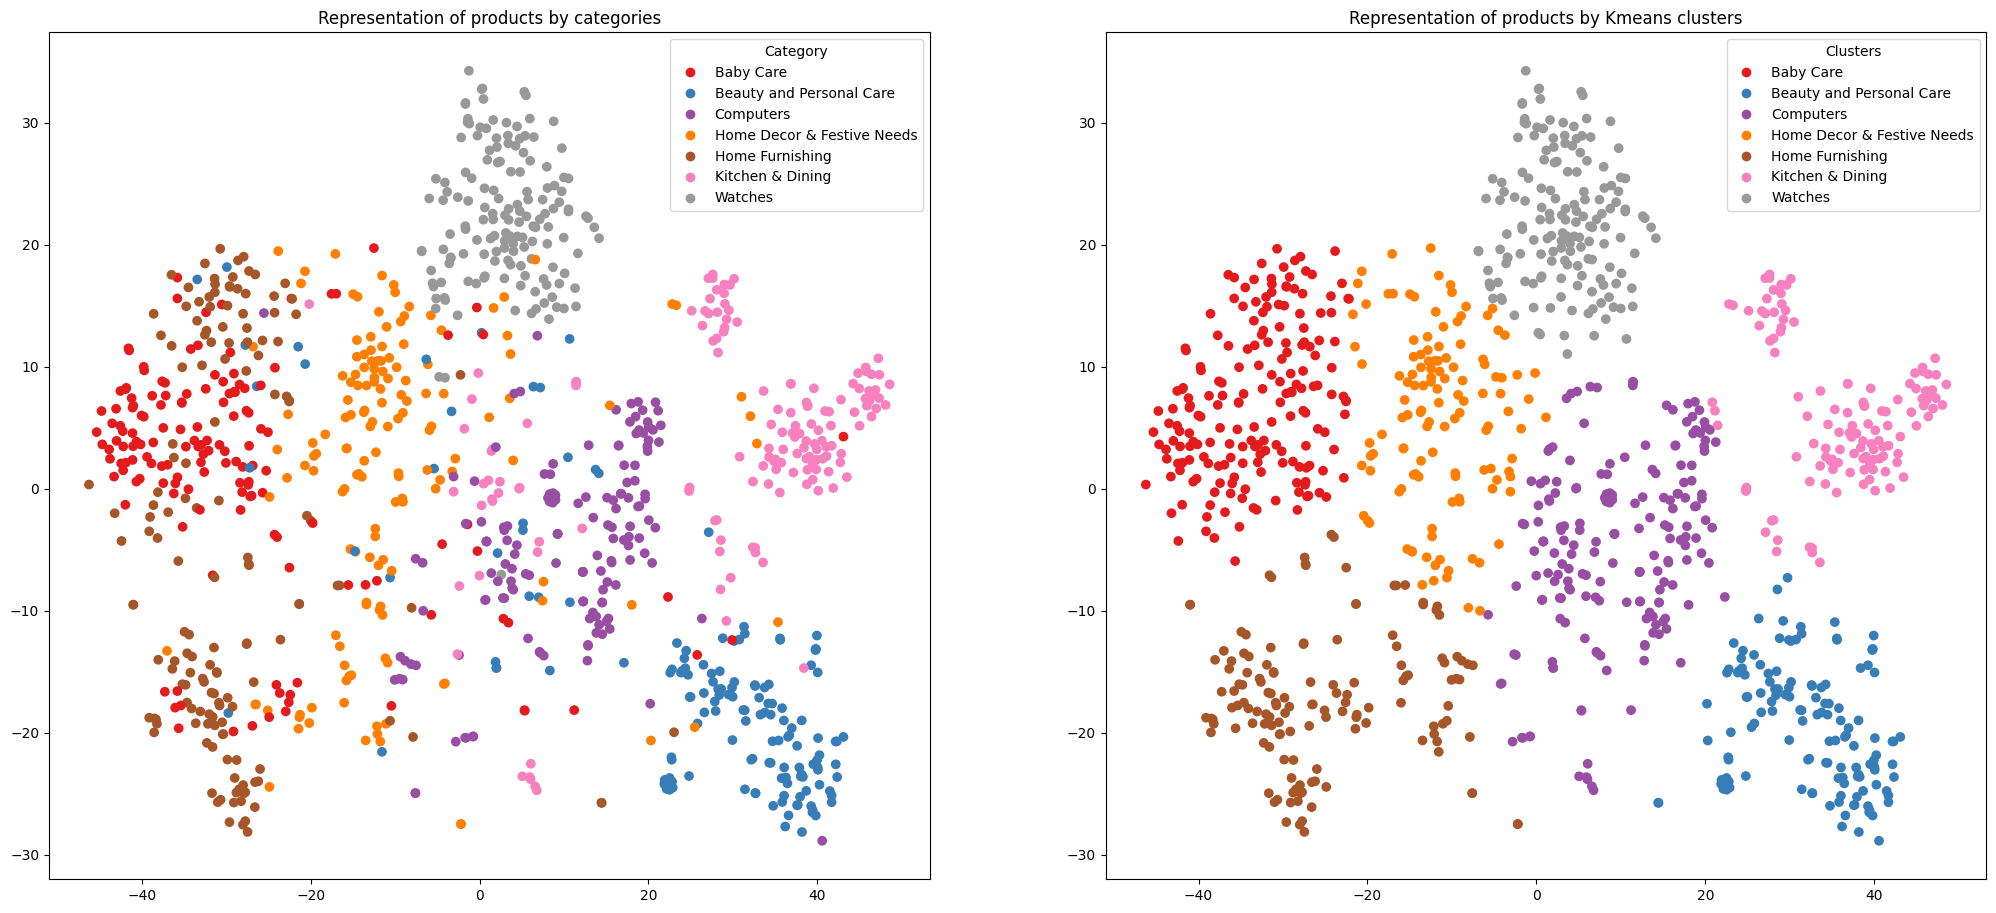

ARI:  0.54  /  SILOUHETTE:  0.48
[4, 0, 6, 3, 5, 1, 2]
[4, 0, 6, 2, 1, 5, 3]


In [168]:
TSNE_visualization(X_tsne_resnet, category_name_resnet, df_tsne_resnet, ARI_resnet, SILOUHETTE_resnet)

In [163]:
category_reindexed_resnet

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Computers',
 'Beauty and Personal Care',
 'Kitchen & Dining',
 'Home Decor & Festive Needs']

In [154]:
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

In [139]:
df_tsne_resnet

,tsne1,tsne2,category,category_encoded,Kmeans_cluster,Transformed_Cluster
0,-30.656040,-25.483385,Home Furnishing,4,2,4
1,-31.597012,-7.082689,Baby Care,0,2,4
2,-35.777611,17.316561,Baby Care,0,4,0
3,-31.904188,-14.419724,Home Furnishing,4,2,4
4,-34.617893,-13.473658,Home Furnishing,4,2,4
...,...,...,...,...,...,...
1045,-29.140291,-19.883663,Baby Care,0,2,4
1046,-23.658232,-16.736462,Baby Care,0,2,4
1047,-22.948561,-18.237337,Baby Care,0,2,4
1048,-24.052170,-16.064213,Baby Care,0,2,4


In [160]:
# Get 3 random ids from the list


[992, 1008, 742]


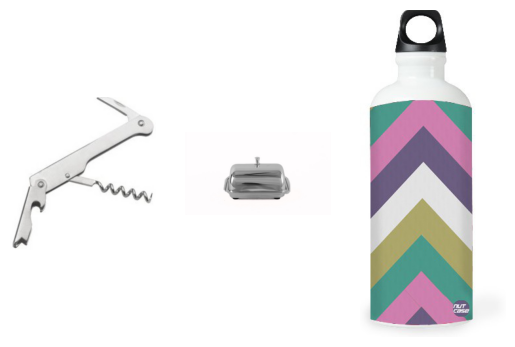

In [191]:
descrip = df_tsne_resnet[(df_tsne_resnet.category_encoded == 5) & (df_tsne_resnet.Transformed_Cluster == 2)]

random_values = random.sample(descrip.index.tolist(), 3)
print(random_values)
#random_values = [39, 918, 934]
#print(random_values)
# print("-------")
for i in range(3):
    plt.subplot(130 + 1 + i)
    filename = df.iloc[random_values[i]]['image']
    image = imread(glob(os.path.join(image_folder, filename))[0])
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [126]:
df.iloc[39]['product_category_tree']

'["Home Furnishing >> JMD Home Furnishing >> JMD Printed Cushions Cover (Pack of 2, 40 cm*40 ..."]'

In [159]:
for i in range(7):
    for j in range(7):
        print(i,j, df_tsne_resnet[(df_tsne_resnet.category_encoded == i) & (df_tsne_resnet.Transformed_Cluster == j)].shape)

0 0 (108, 6)
0 1 (2, 6)
0 2 (9, 6)
0 3 (8, 6)
0 4 (20, 6)
0 5 (1, 6)
0 6 (2, 6)
1 0 (5, 6)
1 1 (117, 6)
1 2 (16, 6)
1 3 (7, 6)
1 4 (2, 6)
1 5 (1, 6)
1 6 (2, 6)
2 0 (1, 6)
2 1 (3, 6)
2 2 (129, 6)
2 3 (4, 6)
2 4 (9, 6)
2 5 (3, 6)
2 6 (1, 6)
3 0 (6, 6)
3 1 (3, 6)
3 2 (8, 6)
3 3 (92, 6)
3 4 (31, 6)
3 5 (5, 6)
3 6 (5, 6)
4 0 (65, 6)
4 1 (3, 6)
4 2 (0, 6)
4 3 (5, 6)
4 4 (77, 6)
4 5 (0, 6)
4 6 (0, 6)
5 0 (0, 6)
5 1 (4, 6)
5 2 (27, 6)
5 3 (5, 6)
5 4 (0, 6)
5 5 (114, 6)
5 6 (0, 6)
6 0 (0, 6)
6 1 (0, 6)
6 2 (1, 6)
6 3 (3, 6)
6 4 (0, 6)
6 5 (0, 6)
6 6 (146, 6)


In [72]:
df_tsne_resnet

,tsne1,tsne2,category,category_encoded,Kmeans_cluster,Transformed_Cluster
0,-31.036581,-26.730608,Home Furnishing,4,1,4
1,-32.403072,-9.817922,Baby Care,0,1,4
2,-29.013216,-8.256608,Baby Care,0,1,4
3,-32.312840,-15.398391,Home Furnishing,4,1,4
4,-35.027790,-14.993627,Home Furnishing,4,1,4
...,...,...,...,...,...,...
1045,-29.585510,-21.197926,Baby Care,0,1,4
1046,-24.024147,-17.606794,Baby Care,0,1,4
1047,-23.287407,-19.081667,Baby Care,0,1,4
1048,-24.420357,-16.956724,Baby Care,0,1,4
